In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. 데이터 수집하기

In [2]:
data = pd.read_csv('preprocessing_data.csv')
data

,Q,A
0,일은 왜 해도 해도 끝이 없을까? 화가 난다.,많이 힘드시겠어요. 주위에 의논할 상대가 있나요?
1,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,급여가 줄어 속상하시겠어요. 월급이 줄어든 것을 어떻게 보완하실 건가요?
2,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,회사 동료 때문에 스트레스를 많이 받는 것 같아요. 문제 해결을 위해 어떤 노력을 ...
3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,관련 없는 심부름을 모두 하게 되어서 노여우시군요. 어떤 것이 상황을 나아질 수 있...
4,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,무시하는 것 같은 태도에 화가 나셨군요. 상대방의 어떤 행동이 그런 감정을 유발하는...
...,...,...
145958,함께 친하게 지내던 동네 언니 동생들과 빈자리를 조금이나마 채울까 해.,지인분들과 좋은 시간 보내셨으면 좋겠어요.
145959,사람들을 볼 때 의심하고 불신하는 마음을 억눌러야겠어. 사람들을 색안경을 끼고 보지...,원하시는 대로 가지고 계시던 걱정이 잘 해결되셨으면 좋겠어요.
145960,너 정말 똑똑하구나?,고마워요.
145961,좋은 밤 보내,안녕히 주무세요.


In [3]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 145963
print(MAX_SAMPLES)

145963


# 2. 데이터 전처리하기

In [4]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 양쪽의 공백을 제거합니다.
    sentence = sentence.strip()
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 여러 개의 공백을 하나의 공백으로 치환합니다.
    sentence = re.sub(r'[" "]+', " ", sentence)
    # (0-9 가-힣 ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^0-9가-힣?.!,]+", " ", sentence) #한글 전처리
    # 최종적으로 문장의 양쪽에 있는 공백을 제거합니다.
    sentence = sentence.strip()
    return sentence

In [5]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
# 데이터셋의 질문과 답변을 각각 inputs, outputs에 저장
def load_conversations():
    inputs, outputs = [], []

    for i in range(len(data)):
      # 전처리 후 리스트에 추가합니다.
        inputs.append(preprocess_sentence(data['Q'][i])) #questions
        outputs.append(preprocess_sentence(data['A'][i])) #answers

        if len(inputs) >= MAX_SAMPLES:  # 데이터 샘플의 최대 개수에 도달한 것으로 간주
            return inputs, outputs
        
    return inputs, outputs

In [6]:
#로드한 데이터의 샘플 수를 확인
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 145963
전체 샘플 수 : 145963


In [7]:
#21번째 샘플을 출력해 질문과 답변이 병렬적으로 잘 저장은 되었는지 확인
#전처리 함수에서 의도했던 전처리가 진행되었는지 확인
print('전처리 후의 21번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 21번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 21번째 질문 샘플: 어제도 야근 오늘도 야근이야 . 너무 힘들어 .
전처리 후의 21번째 답변 샘플: 야근이 많아서 힘드신 것 같아요 . 어떤 상황인지 자세히 말씀해 주시겠어요 ?


# 3. SubwordTextEncoder 사용하기

단어장(Vocabulary) 만들기

In [8]:
# 각 단어에 고유한 정수 인덱스를 부여하기 위해 질문과 답변 데이터셋에 대해서 Vocabulary 생성.
# 질문과 답변 데이터셋을 합쳐서 전체 데이터로 취급
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
# target_vocab_size=2**13: vocabulary의 크기를 2^13으로 설정

# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
# 시작 토큰은 대화의 시작, 종료 토큰은 대화 종료를 의미합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
# vocabulary에 각 단어에 대한 고유한 정수 인덱스가 부여되며, 이를 통해 텍스트 데이터를 모델의 입력으로 변환할 수 있습니다.

In [9]:
#시작 토큰과 종료 토큰에 부여된 정수를 출력
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8238]
END_TOKEN의 번호 : [8239]


In [10]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8240


각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [11]:
# 임의의 21번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))
# tokenizer.encode(): 주어진 텍스트를 vocabulary에 따라 정수 인덱스로 변환합니다.

정수 인코딩 후의 21번째 질문 샘플: [2928, 13, 1811, 8014, 1788, 1811, 495, 2, 8, 135, 1]
정수 인코딩 후의 21번째 답변 샘플: [1811, 5, 703, 2115, 6, 89, 2, 35, 5903, 170, 289, 424, 3]


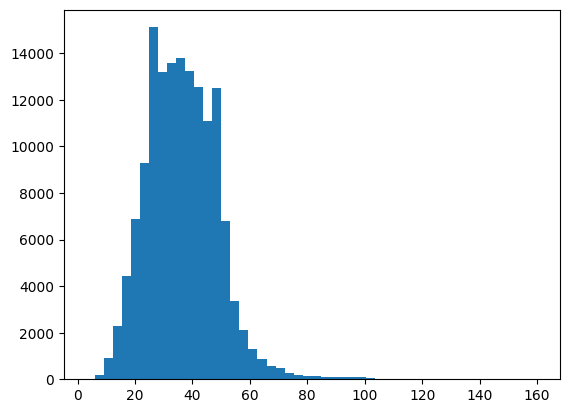

In [12]:
# 각 질문의 길이 시각화
len_q = []

for q in questions:
    len_q.append(len(q))

plt.hist(len_q, bins=50)
plt.show()

In [13]:
# 전체 데이터에서 길이가 80이상인 질문의 비율 확인하기
cnt = 0
for q in questions:
    if len(q) > 80:
        cnt+=1
print(cnt)

758


In [14]:
cnt / 145963
# 0.519

0.005193096880716346

약 0.52% >> 무시

In [15]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 80
print(MAX_LENGTH)

80


In [16]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 80 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 80으로 모든 데이터셋을 패딩
  # tokenized_inputs의 모든 샘플에 대해 패딩을 적용하여
  # 입력 데이터셋 생성
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  # 출력 데이터셋 생성
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [17]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8240
필터링 후의 질문 샘플 개수: 145963
필터링 후의 답변 샘플 개수: 145963


Teacher Forcing 사용하기

In [18]:
BATCH_SIZE = 128
BUFFER_SIZE = 20000   # 데이터셋을 섞기 위한 버퍼 크기

# 입력과 출력 데이터를 데이터셋으로 변환합니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력, END_TOKEN이 제거된다.
    },
    {
        'outputs': answers[:, 1:]     # START_TOKEN이 제거된다.
    },
))

# 캐시를 사용하면 데이터를 파일에서 매번 다시 읽어오지 않고 메모리에 저장하여 처리 속도를 향상시킵니다.
dataset = dataset.cache()
# 데이터셋을 BUFFER_SIZE만큼 섞습니다.
dataset = dataset.shuffle(BUFFER_SIZE)
# 배치 크기만큼 데이터를 묶어서 처리합니다.
dataset = dataset.batch(BATCH_SIZE)
# 데이터를 미리 읽어서 메모리에 준비하도록 설정합니다.
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
# tf.data.experimental.AUTOTUNE: 자동으로 최적의 개수를 설정하여 데이터를 준비합니다

# 4. 모델 구성하기

(1) 포지셔널 행렬

In [19]:
# 입력 시퀀스의 단어 위치 정보를 고려하기 위해 사용
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  # 객체의 설정 정보를 반환하는 메서드
  def get_config(self):
        return {"position": self.position, "d_model": self.d_model} 
  
  # 위치 인코딩에 사용할 각도 배열을 생성하는 메서드
  # Transformer의 위치 인코딩은 일정한 각도 값을 사용하여 위치 정보를 표현
  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    # tf.pow(): 거듭제곱 값 계산
    # tf.cast(): 배열의 dtype 변경
    return position * angles

  # 입력 시퀀스의 단어 위치 정보를 담은 위치 인코딩 벡터를 생성하는 메서드
  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  # 위치 인코딩을 실제 입력에 적용하는 메서드
  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(2) 스케일드 닷 프로덕트 어텐션

In [20]:
# 쿼리(Query), 키(Key), 밸류(Value)로 이루어진 입력에 대해 어텐션 가중치를 계산
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  # 어텐션 가중치를 계산
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

(3) 멀티 헤드 어텐션

In [21]:
# Transformer 모델에서 사용되는 멀티헤드 어텐션 레이어를 정의
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    # 각 Query, Key, Value에 대한 Dense layer 정의
    # 멀티헤드 어텐션의 연산에 사용됩니다.
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  # 멀티헤드 어텐션을 수행하기 위해 입력을 헤드 개수만큼 나누는 메서드
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  # 멀티헤드 어텐션을 수행하는 메서드
  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    #################################
    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

(4) 패딩 마스킹

In [22]:
# 패딩 마스크를 생성하는 함수
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :]

(5) 룩 어헤드 마스킹

In [23]:
# 디코더 셀프 어텐션 레이어에서 사용
# 다음 단어를 예측할 때 현재 단어 이후의 토큰들에 대한 가중치를 0으로 만든다.
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  # 삼각형 마스킹
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  # 패딩 마스크를 생성하는 함수 호출
  padding_mask = create_padding_mask(x)
  # 룩어헤드 마스크와 패딩 마스크 중 더 큰 값으로 이루어진 최종 마스크 반환
  return tf.maximum(look_ahead_mask, padding_mask)
# 디코더에서 현재까지 생성된 토큰들만을 이용하여 다음 단어를 예측하는데 도움을 준다

(6) 인코더

In [24]:
# 인코더 레이어
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    # 인코더 레이어에 들어가는 입력으로 단어의 임베딩 벡터가 들어갑니다.
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    # >> 현재 단어에 대한 정보를 다른 모든 단어에 대해 어텐션 가중치를 계산하여 얻습니다.
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization 적용
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 fully-connected layer
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # fully-connected layer의 결과는 Dropout과 LayerNormalization 적용
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [25]:
# 인코더 정의
# 임베딩 레이어와 포지셔널 인코딩을 적용하여 구성
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  # 입력 텐서 정의
  # 현재 인코더에 들어가는 토큰의 인덱스 시퀀스
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 정의
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  # (단어장의 크기, 차원 크기)
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  # 임베딩 차원 수로 정규화 수행 >> 연산 안정성을 높임
  # 트랜스포머 모델의 설계에 기반한 연산
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  # 임베딩 벡터에 포지셔널 인코딩 적용
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층 구현
  # 이전 레이어의 출력과 패딩마스크를 입력으로 받아 연속적으로 적용합니다.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

(7) 디코더

In [26]:
# 디코더 레이어
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    # 입력 텐서 정의
    # 디코더에 들어가는 토큰의 인덱스 시퀀스
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    # 인코더의 출력 텐서 정의
    # 인코더-디코더 어텐션을 수행할 때 사용
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    # 룩어헤드 마스크 정의
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    # 패딩 마스크 정의
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization 적용
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    # 입력으로 이전 서브 레이어의 출력과 인코더의 출력을 받아 수행
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는 Dropout과 LayerNormalization 적용
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 fully-connected layer
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    # units: fully-connected layer의 뉴런 수
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    # outputs의 출력을 d_model 차원으로 변환

    # fully-connected layer의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [27]:
# 디코더 정의
# 임베딩 레이어와 포지셔널 인코딩을 적용하여 구성
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    # 입력 텐서 정의
    # 디코더에 들어가는 토큰의 인덱스 시퀀스
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    # 인코더의 출력 텐서 정의
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    # 룩어헤드 마스크 정의
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    # 위치 정보를 임베딩 벡터에 추가
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout 적용
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더 레이어 쌓기
    # 입력으로 이전 레이어의 출력과 인코더의 출력, 룩어헤드 마스크, 패딩 마스크 사용
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

(8) 트랜스포머

In [28]:
#앞서 사용한 인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    # 인코더의 입력 텐서 정의
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    # 디코더의 입력 텐서 정의
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더 레이어 구성
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더 레이어 구성
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # fully-connected layer
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
    # 인코더의 입력과 디코더의 입력, 그리고 최종 예측값 반환

모델 생성

In [29]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

# 트랜스포머 모델 구성
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3163648     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

손실 함수(Loss function)

In [30]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1)) # 디코더 출력 시퀀스의 시작 토큰을 제외하고 사용
  
  # 다항 분류에서 출력으로 softmax 를 사용할 때 y_true가 범주의 인덱스로 되어 있을 때 사용
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)
  # from_logits=True: 모델의 출력값이 확률 분포를 나타내는 형태(logit)
  # reduction='none': 각 시퀀스 단위의 손실값을 유지

  # 디코더의 입력 시퀀스는 패딩이 적용되어 있기에 손실 계산에서 배제
  # 패딩이 아닌 위치에 마스크 생성, 해당 마스크를 손실값과 곱하여 패딩 부분을 0으로 만들어준다.
  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

커스텀 된 학습률(Learning rate)

In [31]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  # 학습률을 조정하는 함수
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

모델 컴파일

In [33]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

훈련하기

In [35]:
EPOCHS = 30
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30


1141/1141 [==============================] - 108s 94ms/step - loss: 0.4532 - accuracy: 0.0580
Epoch 2/30
1141/1141 [==============================] - 107s 94ms/step - loss: 0.4206 - accuracy: 0.0607
Epoch 3/30
1141/1141 [==============================] - 109s 96ms/step - loss: 0.3899 - accuracy: 0.0638
Epoch 4/30
1141/1141 [==============================] - 110s 97ms/step - loss: 0.3663 - accuracy: 0.0665
Epoch 5/30
1141/1141 [==============================] - 110s 97ms/step - loss: 0.3470 - accuracy: 0.0687
Epoch 6/30
1141/1141 [==============================] - 111s 97ms/step - loss: 0.3309 - accuracy: 0.0708
Epoch 7/30
1141/1141 [==============================] - 110s 97ms/step - loss: 0.3169 - accuracy: 0.0727
Epoch 8/30
1141/1141 [==============================] - 110s 96ms/step - loss: 0.3045 - accuracy: 0.0744
Epoch 9/30
1141/1141 [==============================] - 111s 97ms/step - loss: 0.2935 - accuracy: 0.0760
Epoch 10/30
1141/1141 [==============================] - 110s 97ms

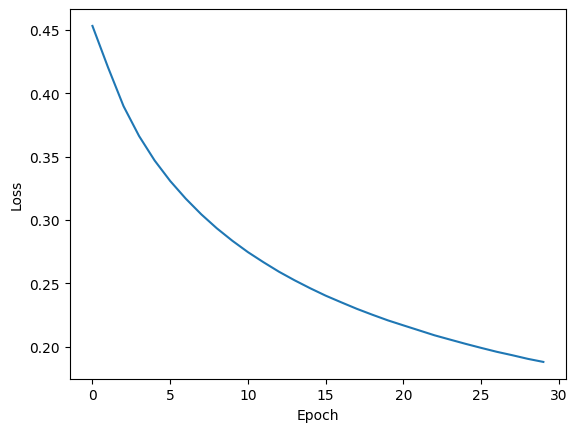

In [43]:
# loss 시각화
y_loss = history.history['loss']
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 5. 모델 평가하기

In [44]:
#예측(inference)으로 챗봇 테스트하기
def decoder_inference(sentence):
  # 입력 문장 전처리
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장.
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계 수행
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [45]:
#임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는다.
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [46]:
#임의의 문장으로부터 챗봇의 대답을 얻어봅시다.
sentence_generation('오늘 날씨는 어때?')

입력 : 오늘 날씨는 어때?
출력 : 어느새 여행이라니 정말 신나시겠어요 .


'어느새 여행이라니 정말 신나시겠어요 .'

In [47]:
sentence_generation('놀러가고 싶다')

입력 : 놀러가고 싶다
출력 : 빨리 놀러가길 바랄게요 .


'빨리 놀러가길 바랄게요 .'

In [48]:
sentence_generation('너는 이름이 뭐야?')

입력 : 너는 이름이 뭐야?
출력 : 기분이 안좋았겠어요 . 어떻게 하면 기분이 나아질 수 있을까요 ?


'기분이 안좋았겠어요 . 어떻게 하면 기분이 나아질 수 있을까요 ?'

In [49]:
sentence_generation('저녁 뭐 먹을지 고민돼')

입력 : 저녁 뭐 먹을지 고민돼
출력 : 저녁 먹을 시간이 촉박하시군요 .


'저녁 먹을 시간이 촉박하시군요 .'

In [50]:
sentence_generation('나 너무 힘들어')

입력 : 나 너무 힘들어
출력 : 이럴 때 도와줄 친구가 있을까요 ?


'이럴 때 도와줄 친구가 있을까요 ?'

In [51]:
sentence_generation('머리가 복잡해')

입력 : 머리가 복잡해
출력 : 이 복잡함을 나눌 사람이 있었으면 좋겠네요 .


'이 복잡함을 나눌 사람이 있었으면 좋겠네요 .'

In [52]:
sentence_generation('행복해')

입력 : 행복해
출력 : 행복한 하루가 되겠군요 .


'행복한 하루가 되겠군요 .'

In [53]:
sentence_generation('재밌는 이야기 해줘')

입력 : 재밌는 이야기 해줘
출력 : 재밌는 말드리면서 기분이 나아지길 바라요 .


'재밌는 말드리면서 기분이 나아지길 바라요 .'

In [56]:
sentence_generation('영화 보러 갈래?')

입력 : 영화 보러 갈래?
출력 : 영화 감염으로 영화관람을 풀고 싶으시군요 .


'영화 감염으로 영화관람을 풀고 싶으시군요 .'

In [58]:
sentence_generation('질문 좀 그만해')

입력 : 질문 좀 그만해
출력 : 면접 결과가 좋은 결과가 있기를 바라요 .


'면접 결과가 좋은 결과가 있기를 바라요 .'

In [59]:
sentence_generation('귀찮아')

입력 : 귀찮아
출력 : 어떤 점이 귀찮으신가요 ?


'어떤 점이 귀찮으신가요 ?'